## Introduction

Let $n$ be a positive integer and $S_n$ the symmetric group on $n$ letters. For a partition $\lambda \dashv n$, let $V_\lambda$ denote the irreducible rational representation of $S_n$ corresponding to $\lambda$. For further partitions $\mu, \nu \dashv n$, the Kronecker coefficients $c_{\mu\nu}^\lambda$ are defined by 
$$V_\mu \otimes V_\nu = \bigoplus_{\lambda \dashv n}V_\lambda^{\oplus c_{\mu\nu}^\lambda}$$

One way of computing the Kronecker coefficients is to determine the direct sum decomposition above using the character theory of the symmetric group. The Kronecker coefficients can also be described in terms of the representation theory of the general linear group, and this provides another route for their computation. 

It has long been conjectured that there exists a combinatorial description of the Kronecker coefficients, where $c_{\mu\nu}^\lambda$ can be computed only by reference to the triple $(\mu, \nu, \lambda)$. Such descriptions are currently known only for certain families of triples. We give one example as follows. For a partition $\chi = (\chi_1, \ldots , \chi_k)$ of some $m < n$ with $n-m \geq \chi_1$, write $n(\chi_1, \ldots , \chi_k)$ for the partition $(n-m, \chi_1, \ldots , \chi_k)$ of $n$. Then for any $n \geq 4$ we have 
$$V_{n(1)}\otimes V_{n(1)} = V_{n(0)} \oplus V_{n(1)} \oplus V_{n(2)} \oplus V_{n(1, 1)}
$$

This repository contains a notebook for training a machine learning model that takes as input a triple $(\mu, \nu, \lambda),$ and outputs a prediction for whether or not the coefficient $c^\lambda_{\mu\nu}$ is zero, a slightly easier problem than actually computing the value itself. The plan is that this will fail, because there probably is not a combinatorial formula for computing the Kronecker coefficients in general. 

It's very easy to design a model that fails to learn a prediction task. So this repository will also contain a notebook for training a model to predict the vanishing behaviour of the Littlewood-Richardson coefficients, a similarly-defined collection of numbers for which a combinatorial method of computation is known to exist. Showing that the same model can solve one prediction task but not the other will hopefully convey in some vague way that one of these tasks is more difficult than the other.

Of course, we should already have this vague understanding that one is more difficult because people have spent 80 years trying to find a combinatorial description of the Kronecker coefficients and have failed to do so. And people have already made precise the fact that the Littlewood-Richardson coefficients are 'easier' than the Kronecker coefficients using [a computational complexity argument](https://arxiv.org/abs/1507.02955). And whether or not you can train a model to do something is not a reliable indicator of whether that task is difficult or not. So this is very much a toy project that isn't really suitable for drawing any real conclusions from.

## Littlewood-Richardson coefficients

For positive integers $n, m$ and partitions $\mu \dashv n$, $\nu \dashv m$, the representation $V_\mu \otimes V_\nu$ of $S_n \times S_m$ is irreducible, and all irreducible rational representations of $S_n \times S_m$ are of this form. For $\lambda$ a partition of $n+m$, the representation $V_\lambda$ of $S_{n+m}$ restricts to a representation $V_\lambda\downarrow_{S_n\times S_m}$ of $S_{n}\times S_m$. The Littlewood-Richardson coefficients $b^\lambda_{\mu\nu}$ are defined by 
$$V_\lambda\downarrow_{S_n\times S_m} = \bigoplus_{\mu \dashv n,~ \nu \dashv m} (V_\mu \otimes V_\nu)^{\oplus b_{\mu\nu}^\lambda}$$

As in the case of the Kronecker coefficients, these coefficients can be computed with knowledge of the relevant character tables of the symmetric groups. Unlike the Kronecker coefficients, there is also a known combinatorial description, [given here](https://en.wikipedia.org/wiki/Littlewood%E2%80%93Richardson_rule#Littlewood%E2%80%93Richardson_tableaux).

## Model architecture

The inspiration for this toy project comes from [a paper that trains a model to generate solutions to differential equations](https://arxiv.org/abs/1912.01412), and we follow their lead in also using a transformer. 

We set the internal dimension to 200, the number of layers to 4, and perform multi-headed attention with 10 heads. I didn't put much thought into this -- this was the first configuration I tried, and since this was sufficient for solving the problem of predicting Littlewood-Richardson coefficients, and since it took over a day to train on my 2014 MacBook Pro, I didn't experiment further.

The only part of the pipeline unique to this problem is how to represent the input data $(\mu, \nu, \lambda)$.

Since a partition $\mu = (\mu_1, \ldots , \mu_k)$ is simply a tuple of non-negative integers, it makes sense to learn an embedding matrix $A$ that will represent this as a tuple of vectors ($A\mu_1, \ldots , A\mu_k)$. Let $a_i$ denote the vector image of the integer $i$ under this embedding. Then the tuple of vectors is given by $(a_{\mu_1}, \ldots , a_{\mu_k})$.

Since the transformer architecture has no knowledge of the order of the given tuples, we train an additional embedding matrix $B$. With notation as above, for a partition $(\mu_1, \ldots , \mu_k)$, we represent the positional information with the tuple $(b_1, \ldots , b_k)$. This is possibly unnecessary since a partition is determined by the set of its parts anyway, but lots of operations with partitions are made easier by ordering the parts, so we may as well save the model the hassle of keeping track.

Finally, we add further positional information in order to distinguish the three input partitions by training an embedding matrix $C$. 

To give a concrete example, suppose $\mu = (3), \nu = (2, 1)$ and $\lambda = (1, 1, 1)$. The input data will be represented by the tuples of vectors

\begin{align} 
a &= (a_3, a_2, a_1, a_1, a_1, a_1), \\
b &= (b_1, b_1, b_2, b_1, b_2, b_3), \\
c &= (c_1, c_2, c_2, c_3, c_3, c_3)
\end{align}

In order to 'remind' the model of the positional information, we add $b + c$ to the output of each round of attention. 

In order to handle variable input lengths, we pad all inputs to a fixed length and mask appropriately throughout the model. To arrive at a prediction, we take the average of the outputs and apply a sigmoid operator.

## Data

Data is generated using [symchar](https://github.com/benenharrington/symchar). We set the maximum number of parts of a partition to 10, the maximumum part value to 10, and generate a complete set of coefficients satisfying these constraints for all $S_n$ up to $n=15$. We hold a 10% sample for validation.

Since the coefficients are symmetric in $\mu$ and $\nu$, and since they appear in various linear relationships with one another, there are plenty of ways information from the training set may 'leak' into the validation set. We're not going to worry about this at all, because we're only really interested in the relative difference between performance for Kronecker coefficients and performance for Littlewood-Richardson coefficients.

## Performance

There are several ways we might measure performance. Treating each individual coefficient's vanishing behaviour as a prediction task, we could measure the overall accuracy. Random guessing would get 50%. Always guessing the most common label (non-vanishing) would get around 70% for our two datasets. 

In the case of the Kronecker coefficients, for any given $(\mu, \nu)$ it would be natural to regard the non-vanishing behaviour of all $c_{\mu\nu}^\lambda$ as a prediction task. Random guessing will give you close to 0% accuracy. Similarly for the Littlewood Richardson coefficients, for each partition $\lambda$ we could regard the non-vanishing behaviour of all $b_{\mu\nu}^\lambda$ as a prediction task.

Since it turns out that the model learns to predict Littlewood-Richardson coefficients with 100% accuracy, it doesn't really matter which metric we choose for comparing with Kronecker coefficients:

(0, 5)

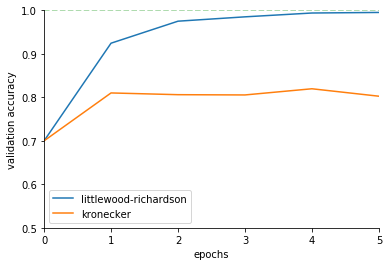

In [25]:
from matplotlib import pyplot as plt
val_data_lr = [0.7, 0.9245, 0.9751, 0.9851, 0.9939, 0.9952]
val_data_kron = [0.7, 0.8101, 0.8061, 0.8055, 0.8197, 0.8026]
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.plot([i for i in range(0, 6)], val_data_lr, label='littlewood-richardson')
plt.plot([i for i in range(0, 6)], val_data_kron, label='kronecker')
plt.plot([i for i in range(0, 6)], [1 for i in range(0, 6)], '--', alpha=0.5)
plt.xticks([i for i in range(0, 6)])
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.legend()
plt.ylim(0.5, 1.0)
plt.xlim(0, 5)

Depending on initial conditions, 100% accuracy is reached for Littlewood-Richardson coefficients within 10-20 epochs, whereas accuracy for Kronecker coefficients fails to improve after the first epoch.

## Next

I think it'd be neat to split off the coefficients for any entire symmetric group as validation, and plot which sorts of partitions get 'solved' as the model trains. Soon!